In this experiment, we do the following:
* Transfer learning using the pre-trained model _Yamnet_ as feature extractor.

Result:
?

Backlog:
* Hyperparameter tuning for the upper layers.

## Part 1: No tuning

Simply replicating Keras example at https://keras.io/examples/audio/uk_ireland_accent_recognition

In [ ]:
%pip install -U -q tensorflow tensorflow_datasets
#apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
%pip install -U -q keras-tuner

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import pathlib
import os
from os.path import isfile, join, splitext

import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
import tensorflow_hub as tfhub
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Sequential
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment
import soundfile as sf
import time

SAMPLING_RATE = 16000
EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_SEED = 42
TUNING_DIRECTORY = "model8_tuning_dir"
PROJECT_NAME = "model8_tuning"
MODEL_NAME = "MODEL8"

# Set the seed value for experiment reproducibility.
tf.random.set_seed(SHUFFLE_SEED)
np.random.seed(SHUFFLE_SEED)

2023-01-23 16:42:19.403695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Prepare Dataset

In [2]:
df_train = pd.read_csv(os.getcwd() + "/data/audio10-aug-train.csv", delimiter= ';')
df_val = pd.read_csv(os.getcwd() + "/data/audio10-aug-val.csv", delimiter=';')
df_test = pd.read_csv(os.getcwd() + "/data/audio10-aug-test.csv", delimiter=';')

# Rewrite file_name to contain file paths
df_train['file_name'] = df_train.apply(
    lambda row: os.path.join(os.getcwd(), 'data/augmented', row['file_name'] + '.wav'), 
    axis=1
)
df_val['file_name'] = df_val.apply(
    lambda row: os.path.join(os.getcwd(), 'data/augmented', row['file_name'] + '.wav'), 
    axis=1
)
df_test['file_name'] = df_test.apply(
    lambda row: os.path.join(os.getcwd(), 'data/augmented', row['file_name'] + '.wav'), 
    axis=1
)

class_names = df_train['class_labels'].unique()
# lang_idxs = range(len(class_names))
# class_dict = dict(zip(class_names, lang_idxs))
print(f"Success loading dataset! There are {len(class_names)} classes.")


Success loading dataset! There are 53 classes.


In [3]:
yamnet_model = tf.saved_model.load('./yamnet_1')

2023-01-23 16:43:02.694440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)
    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model(audio_wav)

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    # labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names)))


def dataframe_to_dataset(df_x, df_y, batch_size=64):
    # Convert the labels into numbers -- no longer necessary since we're targetting the class_labels column
    # dataframe['native_langs'] = dataframe.apply(
    #     lambda row: class_dict[row['native_langs']],
    #     axis=1
    # )

    dataset = tf.data.Dataset.from_tensor_slices((df_x, df_y))

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [5]:
X_train = df_train.iloc[:, :-1]
X_val = df_val.iloc[:, :-1]
X_test = df_test.iloc[:, :-1]
y_train = df_train['class_labels']
y_val = df_val['class_labels']
y_test = df_test['class_labels']

print(f'''
Splitting success!
X_train: {len(X_train)}, y_train: {len(y_train)}
X_val: {len(X_val)}, y_val: {len(y_val)}
X_test: {len(X_test)}, y_test: {len(y_test)}
''')

train_ds = dataframe_to_dataset(X_train['file_name'], y_train)
val_ds = dataframe_to_dataset(X_val['file_name'], y_val)
test_ds = dataframe_to_dataset(X_test['file_name'], y_test)

print('Conversion to dataset success!')


Splitting success!
X_train: 10400, y_train: 10400
X_val: 1165, y_val: 1165
X_test: 1165, y_test: 1165

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-23 16:43:18.791656: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


Conversion to dataset success!


### Build model

In [30]:
keras.backend.clear_session()


def build_and_compile_model():
    inputs = keras.layers.Input(shape=(1024), name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.8, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.8, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.5, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.5, name="dropout_4")(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="ouput")(
        x
    )

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1.9644e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

    return model


model = build_and_compile_model()
model.summary()

Model: "accent_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 384)               98688     
                                                                 
 dropout_2 (Dropout)         (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 192)               73920     
                                                                 
 dropout_3 (Dropout)         (None, 192)        

In [31]:
class_counts = tf.zeros(shape=(len(class_names),), dtype=tf.int32)

for x, y in iter(train_ds):
    class_counts = class_counts + tf.math.bincount(
        tf.cast(tf.math.argmax(y, axis=1), tf.int32), minlength=len(class_names)
    )

class_weight = {
    i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()
    for i in range(len(class_counts))
}

print(class_weight)

{0: 1.6857467700258397, 1: inf, 2: inf, 3: 195.6928351045595, 4: inf, 5: inf, 6: 80.63794321231812, 7: 10.496975046431658, 8: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf, 15: inf, 16: inf, 17: inf, 18: inf, 19: inf, 20: inf, 21: 102.92751532636134, 22: 224.12092658029053, 23: 132.93805309734512, 24: inf, 25: inf, 26: 70.21353013530135, 27: inf, 28: inf, 29: inf, 30: inf, 31: inf, 32: inf, 33: inf, 34: inf, 35: inf, 36: inf, 37: inf, 38: 196.36601307189542, 39: inf, 40: 52.50515084621045, 41: inf, 42: inf, 43: 4.8086597590767415, 44: 130.53647381660187, 45: inf, 46: inf, 47: inf, 48: inf, 49: 54.599330463892876, 50: inf, 51: inf, 52: inf}


/var/folders/3p/fc9cp69s1lsfgnzqtqtddvz00000gn/T/ipykernel_80746/1312827400.py:9: RuntimeWarning: divide by zero encountered in int_scalars
  i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()


In [32]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=10, restore_best_weights=True
)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_NAME + ".h5", monitor="val_auc", save_best_only=True
)

tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

### Train & evaluate model

In [33]:
fitting_start_time = time.time()

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2,
)

fitting_elapsed_time = time.time() - fitting_start_time
print(f'Training complete! Elapsed time: {fitting_elapsed_time:.3f} seconds')

# Elapsed training time = 22m 15s

Epoch 1/50
8920/8920 - 96s - loss: 43.5579 - accuracy: 0.1464 - auc: 0.8464 - val_loss: 1.5476 - val_accuracy: 0.0081 - val_auc: 0.8686 - 96s/epoch - 11ms/step
Epoch 2/50
8920/8920 - 86s - loss: 34.5409 - accuracy: 0.1634 - auc: 0.9286 - val_loss: 1099.2583 - val_accuracy: 0.2214 - val_auc: 0.7537 - 86s/epoch - 10ms/step
Epoch 3/50
8920/8920 - 85s - loss: 60451.7344 - accuracy: 0.1550 - auc: 0.6798 - val_loss: 20987.7266 - val_accuracy: 0.2214 - val_auc: 0.7537 - 85s/epoch - 10ms/step
Epoch 4/50
8920/8920 - 86s - loss: 5329163.5000 - accuracy: 0.2146 - auc: 0.7552 - val_loss: 182642.8438 - val_accuracy: 0.2214 - val_auc: 0.7537 - 86s/epoch - 10ms/step
Epoch 5/50
8920/8920 - 83s - loss: 25528292.0000 - accuracy: 0.2142 - auc: 0.7550 - val_loss: 642201.1250 - val_accuracy: 0.2214 - val_auc: 0.7537 - 83s/epoch - 9ms/step
Epoch 6/50
8920/8920 - 78s - loss: 77660848.0000 - accuracy: 0.2119 - auc: 0.7524 - val_loss: 1617570.0000 - val_accuracy: 0.2214 - val_auc: 0.7537 - 78s/epoch - 9ms/step

### Let's try without the class weights

In [37]:
fitting_start_time = time.time()

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=2,
)

fitting_elapsed_time = time.time() - fitting_start_time
print(f'Training complete! Elapsed time: {fitting_elapsed_time:.3f} seconds')

Epoch 1/50
8920/8920 - 121s - loss: 1.1054 - accuracy: 0.0680 - auc: 0.9075 - val_loss: 1.4435 - val_accuracy: 0.0120 - val_auc: 0.9001 - 121s/epoch - 14ms/step
Epoch 2/50
8920/8920 - 100s - loss: 0.9584 - accuracy: 0.1205 - auc: 0.9327 - val_loss: 1.0380 - val_accuracy: 0.0679 - val_auc: 0.9512 - 100s/epoch - 11ms/step
Epoch 3/50
8920/8920 - 97s - loss: 0.9325 - accuracy: 0.1370 - auc: 0.9343 - val_loss: 42.7140 - val_accuracy: 0.0208 - val_auc: 0.5152 - 97s/epoch - 11ms/step
Epoch 4/50
8920/8920 - 98s - loss: 61.3420 - accuracy: 0.2558 - auc: 0.8046 - val_loss: 257762.8281 - val_accuracy: 0.0000e+00 - val_auc: 0.4905 - 98s/epoch - 11ms/step
Epoch 5/50
8920/8920 - 101s - loss: 349859.5312 - accuracy: 0.2769 - auc: 0.8253 - val_loss: 1600333.6250 - val_accuracy: 0.0000e+00 - val_auc: 0.4905 - 101s/epoch - 11ms/step
Epoch 6/50
8920/8920 - 105s - loss: 3331675.7500 - accuracy: 0.2795 - auc: 0.8285 - val_loss: 5217315.5000 - val_accuracy: 0.0000e+00 - val_auc: 0.4905 - 105s/epoch - 12ms/s

In [38]:
train_loss, train_acc, train_auc = model.evaluate(train_ds)
valid_loss, valid_acc, valid_auc = model.evaluate(val_ds)
test_loss, test_acc, test_auc = model.evaluate(test_ds)

1071/1071 [==============================] - 10s 9ms/step - loss: 1.0046 - accuracy: 0.0682 - auc: 0.9523


In [39]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

train d-prime: 2.311, validation d-prime: 2.343


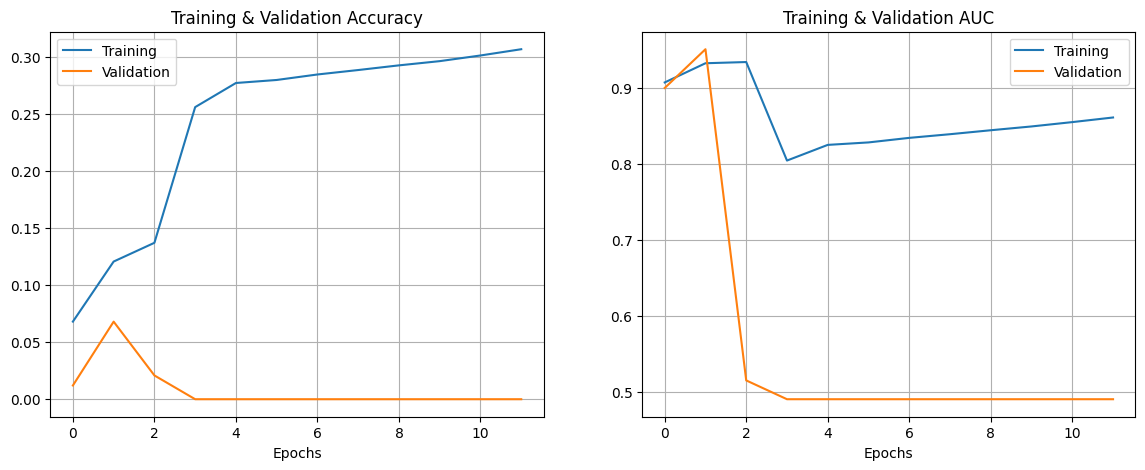

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(len(history.history["auc"])), history.history["auc"], label="Training")
axs[1].plot(range(len(history.history["val_auc"])), history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()

## Part 2: With hyperparameter tuning

In [6]:
def build_and_compile_model(hp):
    inputs = keras.layers.Input(shape=(1024), name="embedding")

    # Tune the number of units in the first Dense layer. Choose an optimal value between 32-512
    hp_units = hp.Int('dense_layer_1', min_value=32, max_value=512, step=32)
    x = keras.layers.Dense(units=hp_units, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="ouput")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    # Tune the learning rate for the optimizer. Choose an optimal value from 0.001, 0.0001, or 1.9644e-5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1.9644e-5])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )
    # model.summary()

    return model

In [7]:
# Instantiate the hyperparameter tuner. 
# Set overwrite=False to continue the search from last session, overwrite=True to start new search everytime.

tuner = kt.Hyperband(build_and_compile_model,
                    objective='val_accuracy',
                    max_epochs=20,
                    factor=3,
                    hyperband_iterations=10,
                    directory=TUNING_DIRECTORY,
                    project_name=PROJECT_NAME,
                    overwrite=False)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, 
            epochs=20, 
            validation_data=val_ds, 
            callbacks=[stop_early],
            verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layers is {best_hps.get('dense_layer_1')}. 
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Time elapsed so far: 9h 52m 55s

INFO:tensorflow:Reloading Oracle from existing project model8_tuning_dir/model8_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from model8_tuning_dir/model8_tuning/tuner0.json

Search: Running Trial #55

Value             |Best Value So Far |Hyperparameter
96                |64                |dense_layer_1
0.001             |0.0001            |learning_rate
20                |3                 |tuner/epochs
7                 |0                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
1                 |0                 |tuner/round
0050              |None              |tuner/trial_id

Epoch 8/20
8930/8930 - 2173s - loss: 2.0914 - accuracy: 0.7246 - auc: 0.9468 - val_loss: 39.2639 - val_accuracy: 0.0144 - val_auc: 0.4977 - 2173s/epoch - 243ms/step
Epoch 9/20
8930/8930 - 63s - loss: 0.9799 - accuracy: 0.8140 - auc: 0.9773 - val_loss: 26.1450 - val_accuracy: 0.0144 - val_auc: 0.4977 - 63s/epoch - 7ms/step
Epoch 10/20
8930/8930 - 66s - loss: 0.8058 - a

KeyboardInterrupt: 

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_NAME + ".h5", monitor="val_accuracy", save_best_only=True
)

tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
hp = kt.HyperParameters()

fitting_start_time = time.time()

history = hypermodel.fit(train_ds, 
                        validation_data=val_ds,
                        epochs=EPOCHS,
                        class_weight=class_weight,
                        batch_size=hp.Choice(name='batch_size', values=[16, 32]),
                        callbacks=callbacks,
                        verbose=2)

fitting_elapsed_time = time.time() - fitting_start_time
print(f'Training complete! Elapsed time: {fitting_elapsed_time:.3f} seconds')

In [ ]:
train_loss, train_acc, train_auc = hypermodel.evaluate(train_ds)
valid_loss, valid_acc, valid_auc = hypermodel.evaluate(val_ds)
test_loss, test_acc, test_auc = hypermodel.evaluate(test_ds)

In [ ]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(len(history.history["auc"])), history.history["auc"], label="Training")
axs[1].plot(range(len(history.history["val_auc"])), history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()